# Original PanAns Comparison

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
from gsw import SA_from_SP, p_from_z

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

#figdir = '/g/data/v45/akm157/figures/IAF_meltwater/'

In [2]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34911/status,
Dashboard: /proxy/34911/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42039,Workers: 0
Dashboard: /proxy/34911/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:34541,Total threads: 1
Dashboard: /proxy/39691/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:44591,


## Testing for corrupted file

In [3]:
path_test_M = xr.open_dataset('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/output022/20020101.ocean_month.nc')
path_test_C =  xr.open_mfdataset(np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/2002*.ocean_month.nc')), chunks='auto')
cont = xr.open_dataset('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/output022/20020101.ocean_month_z.nc')

In [4]:
# shelf masking:
contour_file = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc')
shelf_mask = contour_file['contour_masked_above'].to_numpy()
yh = contour_file['yh'] #slice to match lat_slice
xh = contour_file['xh']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yh', yh.values), ('xh', xh.values)])

In [5]:
area_old = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello']
var = cont['so'].isel(z_l=0)
area_corr = area_old*(var*0 +1)
area = (area_corr*shelf_mask).load()
area_sum = area.sum(dim={'xh','yh'}).load()

In [6]:
test_runoff_M = path_test_M['lrunoff']
test_runoff_C = path_test_C['lrunoff']
test_runoff_anom = test_runoff_M - test_runoff_C

In [7]:
test_runoff_time_C = (test_runoff_C*area_test).sum('xh').sum('yh')/area_sum
test_runoff_time_M = (test_runoff_M*area_test).sum('xh').sum('yh')/area_sum
test_runoff_time = (test_runoff_anom*area_test).sum('xh').sum('yh')/area_sum

NameError: name 'area_test' is not defined

In [ ]:
test_runoff_time_C.sel(time=slice('2002-01-02','2002-07-01')).plot(label='control')
test_runoff_time_M.plot(label='melt')
test_runoff_time.plot(label='anomaly')
plt.xlim
plt.legend()

so output022 file from the perturbation is the issue. 

In [ ]:
test_space_M = test_runoff_M.sel(time='2002-05') #problem month
test_space_C = test_runoff_C.sel(time='2002-05')
test_space_M

In [ ]:
# Get only the non-zero values
grid = test_space_M.drop_vars('time')
# If grid is xarray, get the underlying NumPy array
arr = grid.values if hasattr(grid, "values") else grid

# Flatten to 1D
non_zero_values = arr[arr != 0].ravel()

# Check if all non-zero values are equal
all_same = np.all(non_zero_values == non_zero_values[0]) if non_zero_values.size > 0 else True

print("All non-zero cells have the same value:", all_same)

## Plotting the PanAns

In [3]:
save_dir = '/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/'

runoff_pert_01 = xr.open_dataarray(save_dir + 'runoff_pert_pan01.nc')
runoff_minus_restoring_change_01 = xr.open_dataarray(save_dir + 'runoff_minus_restoring_change_pan01.nc')
restoring_change_01 = xr.open_dataarray(save_dir + 'restoring_change_pan01.nc')

runoff_pert_005 = xr.open_dataarray(save_dir + 'runoff_pert_pan005.nc')
runoff_minus_restoring_change_005 = xr.open_dataarray(save_dir + 'runoff_minus_restoring_change_pan005.nc')
restoring_change_005 = xr.open_dataarray(save_dir + 'restoring_change_pan005.nc')

In [4]:
runoff_pert_01 = runoff_pert_01.to_series()
runoff_minus_restoring_change_01 = runoff_minus_restoring_change_01.to_series()
restoring_change_01 = restoring_change_01.to_series()

runoff_pert_005 = runoff_pert_005.to_series()
runoff_minus_restoring_change_005 = runoff_minus_restoring_change_005.to_series()
restoring_change_005 = restoring_change_005.to_series()

In [5]:
runoff_pert_oldacc = xr.open_dataarray(save_dir + 'runoff_pert_oldaccess.nc')
runoff_minus_restoring_change_oldacc = xr.open_dataarray(save_dir + 'runoff_minus_restoring_change_oldaccess.nc')
restoring_change_oldacc = xr.open_dataarray(save_dir + 'restoring_change_oldaccess.nc')

runoff_pert_oldacc = runoff_pert_oldacc.to_series()
runoff_minus_restoring_change_oldacc = runoff_minus_restoring_change_oldacc.to_series()
restoring_change_oldacc = restoring_change_oldacc.to_series()

In [6]:
import matplotlib.lines as mlines
import matplotlib.dates as mdates

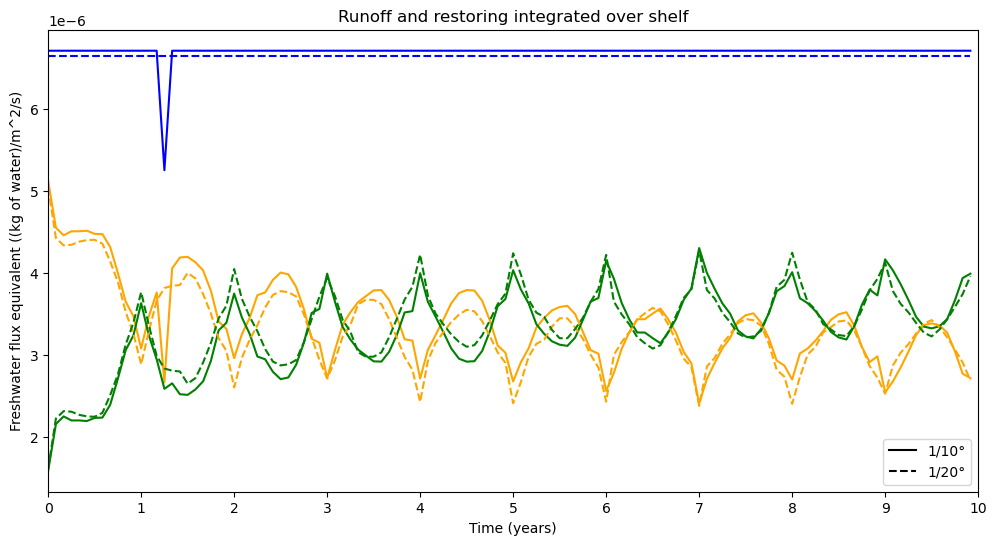

In [7]:
plt.figure(figsize=(12, 6))

# Plot 1/10th degree
runoff_pert_01.plot(label='runoff perturbation 1/10th', color='b')
runoff_minus_restoring_change_01.plot(label='runoff minus restoring change 1/10th', color='orange')
restoring_change_01.plot(label='restoring change 1/10th', color='g')

# Plot 1/20th degree
runoff_pert_005.plot(label='runoff perturbation 1/20th', color='b', linestyle='--')
runoff_minus_restoring_change_005.plot(label='runoff minus restoring change 1/20th', color='orange', linestyle='--')
restoring_change_005.plot(label='restoring change 1/20th', color='g', linestyle='--')

# Custom legend (solid = 1/10°, dashed = 1/20°)
line_10 = mlines.Line2D([], [], color='black', linestyle='-', label='1/10°')
line_20 = mlines.Line2D([], [], color='black', linestyle='--', label='1/20°')
plt.legend(handles=[line_10, line_20], loc='lower right')

# Set ticks every 12 months but label in years
ticks = range(0, 121, 12)  # 0 to 120 months
labels = [str(i) for i in range(len(ticks))]
plt.xticks(ticks=ticks, labels=labels)

plt.xlim(0,120)
plt.xlabel('Time (years)')
plt.ylabel('Freshwater flux equivalent ((kg of water)/m^2/s)')
plt.title('Runoff and restoring integrated over shelf')

plt.show()


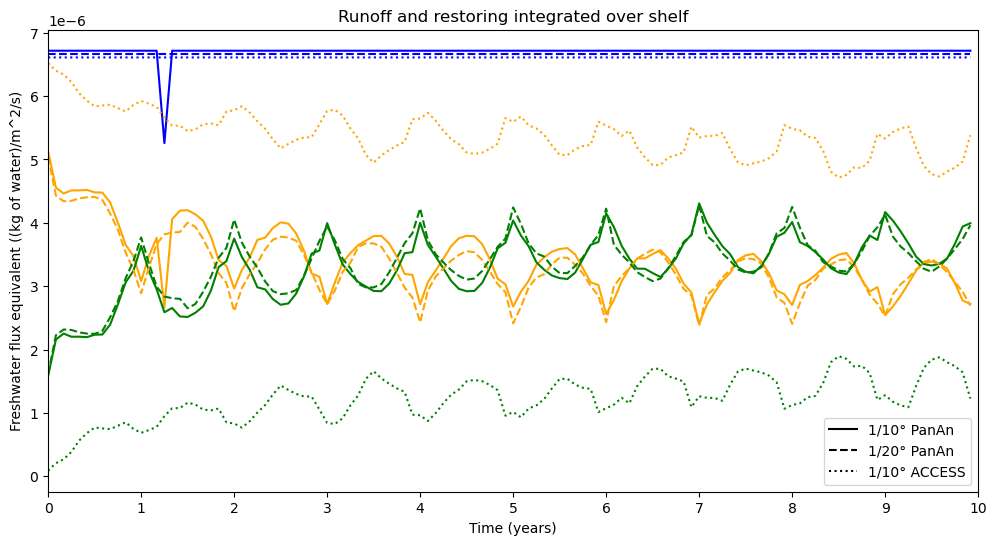

In [8]:
plt.figure(figsize=(12, 6))

# Plot 1/10th degree
runoff_pert_01.plot(label='runoff perturbation 1/10th', color='b')
runoff_minus_restoring_change_01.plot(label='runoff minus restoring change 1/10th', color='orange')
restoring_change_01.plot(label='restoring change 1/10th', color='g')

# Plot 1/20th degree
runoff_pert_005.plot(label='runoff perturbation 1/20th', color='b', linestyle='--')
runoff_minus_restoring_change_005.plot(label='runoff minus restoring change 1/20th', color='orange', linestyle='--')
restoring_change_005.plot(label='restoring change 1/20th', color='g', linestyle='--')

# Plot ACCESS
runoff_pert_oldacc.plot(label='runoff perturbation 1/20th', color='b', linestyle=':')
runoff_minus_restoring_change_oldacc.plot(label='runoff minus restoring change 1/20th', color='orange', linestyle=':')
restoring_change_oldacc.plot(label='restoring change 1/20th', color='g', linestyle=':')

# Custom legend (solid = 1/10°, dashed = 1/20°)
line_10 = mlines.Line2D([], [], color='black', linestyle='-', label='1/10° PanAn')
line_20 = mlines.Line2D([], [], color='black', linestyle='--', label='1/20° PanAn')
line_ACC = mlines.Line2D([], [], color='black', linestyle=':', label='1/10° ACCESS')
plt.legend(handles=[line_10, line_20, line_ACC], loc='lower right')

# Set ticks every 12 months but label in years
ticks = range(0, 121, 12)  # 0 to 120 months
labels = [str(i) for i in range(len(ticks))]
plt.xticks(ticks=ticks, labels=labels)

plt.xlim(0,120)
plt.xlabel('Time (years)')
plt.ylabel('Freshwater flux equivalent ((kg of water)/m^2/s)')
plt.title('Runoff and restoring integrated over shelf')

plt.show()


In [9]:
# Apply 12-month running mean (pandas)
rp01 = runoff_pert_01.rolling(window=12, center=True).mean()
rmr01 = runoff_minus_restoring_change_01.rolling(window=12, center=True).mean()
rc01 = restoring_change_01.rolling(window=12, center=True).mean()

rp005 = runoff_pert_005.rolling(window=12, center=True).mean()
rmr005 = runoff_minus_restoring_change_005.rolling(window=12, center=True).mean()
rc005 = restoring_change_005.rolling(window=12, center=True).mean()

rp_old = runoff_pert_oldacc.rolling(window=12, center=True).mean()
rmr_old = runoff_minus_restoring_change_oldacc.rolling(window=12, center=True).mean()
rc_old = restoring_change_oldacc.rolling(window=12, center=True).mean()

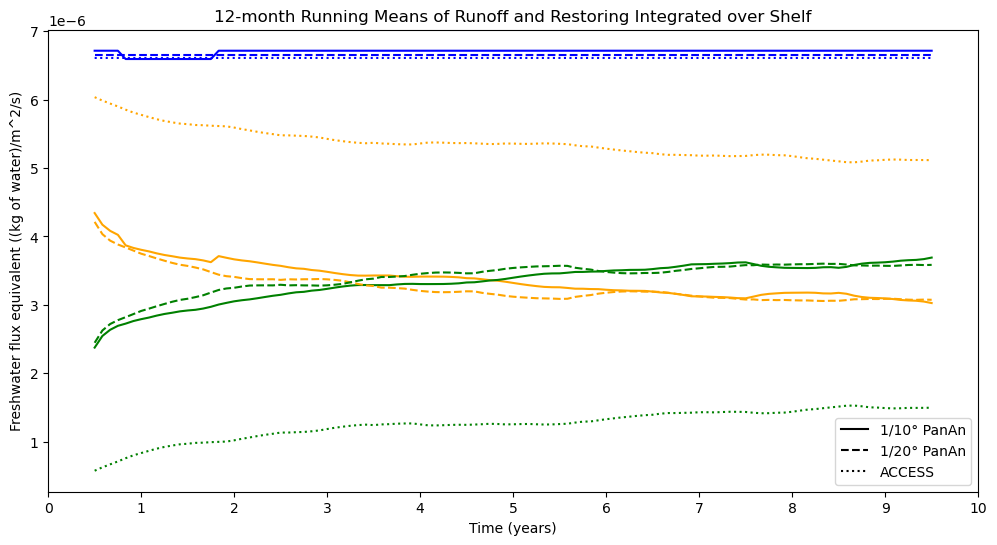

In [10]:
plt.figure(figsize=(12, 6))

# Plot 1/10th degree
rp01.plot(label='runoff perturbation 1/10th', color='b')
rmr01.plot(label='runoff minus restoring change 1/10th', color='orange')
rc01.plot(label='restoring change 1/10th', color='g')

# Plot 1/20th degree
rp005.plot(label='runoff perturbation 1/20th', color='b', linestyle='--')
rmr005.plot(label='runoff minus restoring change 1/20th', color='orange', linestyle='--')
rc005.plot(label='restoring change 1/20th', color='g', linestyle='--')

# Plot ACCESS
rp_old.plot(label='runoff perturbation ACCESS', color='b', linestyle=':')
rmr_old.plot(label='runoff minus restoring change ACCESS', color='orange', linestyle=':')
rc_old.plot(label='restoring change ACCESS', color='g', linestyle=':')

# Custom legend (solid = 1/10°, dashed = 1/20°, dotted = ACCESS)
line_10 = mlines.Line2D([], [], color='black', linestyle='-', label='1/10° PanAn')
line_20 = mlines.Line2D([], [], color='black', linestyle='--', label='1/20° PanAn')
line_ACC = mlines.Line2D([], [], color='black', linestyle=':', label='ACCESS')
plt.legend(handles=[line_10, line_20, line_ACC], loc='lower right')

# Set ticks every 12 months but label in years
ticks = range(0, 121, 12)  # 0 to 120 months
labels = [str(i) for i in range(len(ticks))]
plt.xticks(ticks=ticks, labels=labels)

plt.xlim(0, 120)
plt.xlabel('Time (years)')
plt.ylabel('Freshwater flux equivalent ((kg of water)/m^2/s)')
plt.title('12-month Running Means of Runoff and Restoring Integrated over Shelf')

plt.show()


### Converting to Sv

Step 1: Recognize the conversion

kg/m²/s → m/s of water:
For freshwater, density ≈ 1000 kg/m³, so

$$ \text{velocity equivalent (m/s)} = \frac{flux (kg/m²/s)}{1000 kg/m³} $$

Multiply by area to get volume flux (m³/s). If your flux is integrated over the shelf area, then

$$ \text{volume flux (m³/s)} = \frac{flux (kg/m²/s)}{1000} × area (m²) $$

Convert to Sv: $ 1 Sv = 10^{6} m³/s $, so divide by $10^{6}$.

**First I'm finding the shelf area sum for each model:**

The method below is really clunky, don't mind that

In [11]:
## ACCESS shelf mask
# shelf masking:
contour_file_acc = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask_acc = contour_file_acc['contour_masked_above']
yt_ocean = contour_file_acc['yt_ocean'] #slice to match lat_slice
xt_ocean = contour_file_acc['xt_ocean']
# Mask values that are non-zero
shelf_mask_acc[np.where(shelf_mask_acc!=0)] = np.nan
shelf_mask_acc = shelf_mask_acc+1
shelf_mask_acc = xr.DataArray(shelf_mask_acc, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

## Pan01 shelf mask
# shelf masking:
contour_file_01 = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc')
shelf_mask_01 = contour_file_01['contour_masked_above'].to_numpy()
yh_01 = contour_file_01['yh'] #slice to match lat_slice
xh_01 = contour_file_01['xh']
# Mask values that are non-zero
shelf_mask_01[np.where(shelf_mask_01!=0)] = np.nan
shelf_mask_01 = shelf_mask_01+1
shelf_mask_01 = xr.DataArray(shelf_mask_01, coords = [('yh', yh_01.values), ('xh', xh_01.values)])


## Pan005 shelf mask
# shelf masking:
contour_file_005 = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc')
shelf_mask_005 = contour_file_005['contour_masked_above'].to_numpy()
yh_005 = contour_file_005['yh'] #slice to match lat_slice
xh_005 = contour_file_005['xh']
# Mask values that are non-zero
shelf_mask_005[np.where(shelf_mask_005!=0)] = np.nan
shelf_mask_005 = shelf_mask_005+1
shelf_mask_005 = xr.DataArray(shelf_mask_005, coords = [('yh', yh_005.values), ('xh', xh_005.values)])

In [12]:
shelf_mask_acc

<xarray.DataArray (yt_ocean: 510, xt_ocean: 3600)> Size: 7MB
array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * yt_ocean  (yt_ocean) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95

In [13]:
# ACCESS shelf area
acc_area_old = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output040/ocean/ocean_grid.nc')['area_t']
acc_var = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output040/ocean/ocean.nc')['salt'].isel(time=0,st_ocean=0)

In [14]:
acc_area_corr = acc_area_old*(acc_var*0 +1)

In [15]:
acc_area = (acc_area_corr*shelf_mask_acc)
acc_area_sum = acc_area.sum(dim={'xt_ocean','yt_ocean'})

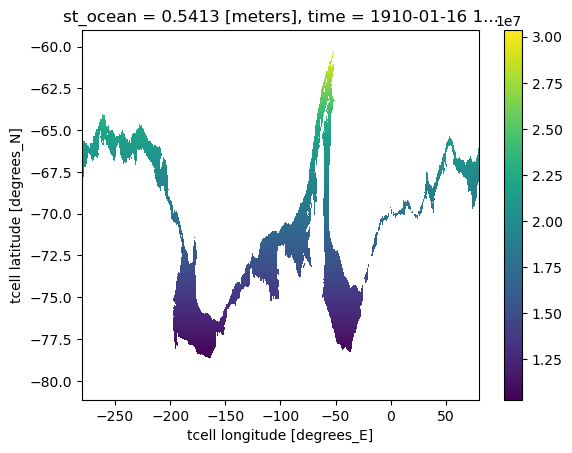

In [16]:
acc_area.plot()

In [17]:
# Pan01 shelf area
pan01_area_old = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello']
pan01_var = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_month_z.nc')['so'].isel(time=0,z_l=0)
pan01_area_corr = pan01_area_old*(pan01_var*0 +1)
pan01_area = (pan01_area_corr*shelf_mask_01).load()
pan01_area_sum = pan01_area.sum(dim={'xh','yh'}).load()

In [18]:
# Pan005 shelf area
pan005_area_old = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output030/19930701.ocean_static.nc')['areacello']
pan005_var = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output030/19930701.ocean_month_z.nc')['so'].isel(time=0,z_l=0)
pan005_area_corr = pan005_area_old*(pan005_var*0 +1)
pan005_area = (pan005_area_corr*shelf_mask_005).load()
pan005_area_sum =pan005_area.sum(dim={'xh','yh'}).load()

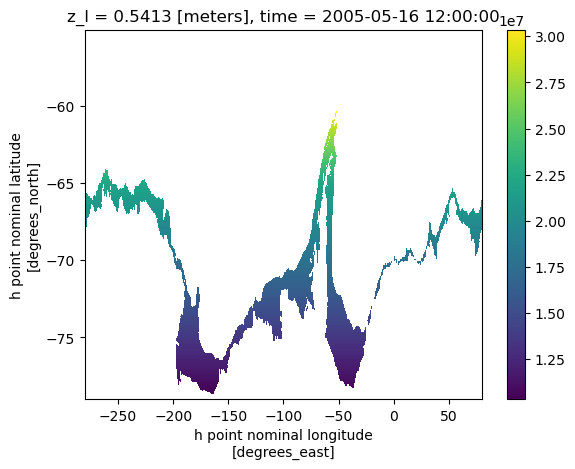

In [19]:
pan01_area.plot()

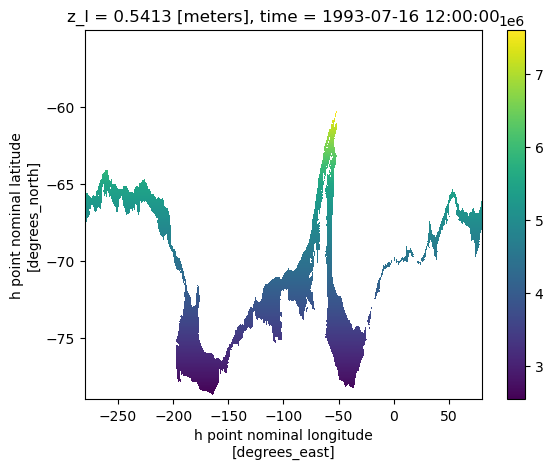

In [20]:
pan005_area.plot()

In [21]:
rp01

time
2001-01-16 12:00:00   NaN
2001-02-15 00:00:00   NaN
2001-03-16 12:00:00   NaN
2001-04-16 00:00:00   NaN
2001-05-16 12:00:00   NaN
                       ..
2010-08-16 12:00:00   NaN
2010-09-16 00:00:00   NaN
2010-10-16 12:00:00   NaN
2010-11-16 00:00:00   NaN
2010-12-16 12:00:00   NaN
Length: 120, dtype: float64

In [22]:
pan01_area_sum

<xarray.DataArray ()> Size: 4B
array(2.864998e+12, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 2005-05-16 12:00:00

**Now using shelf sum to convert to Sv**:

In [23]:
# Convert already-integrated fluxes to Sv
rp01_Sv  = rp01  * pan01_area_sum.values / 1000 / 1e6
rmr01_Sv = rmr01 * pan01_area_sum.values / 1000 / 1e6
rc01_Sv  = rc01  * pan01_area_sum.values / 1000 / 1e6

rp005_Sv  = rp005  * pan005_area_sum.values / 1000 / 1e6
rmr005_Sv = rmr005 * pan005_area_sum.values / 1000 / 1e6
rc005_Sv  = rc005  * pan005_area_sum.values / 1000 / 1e6

rpacc_Sv  = rp_old  * acc_area_sum.values / 1000 / 1e6
rmracc_Sv = rmr_old * acc_area_sum.values / 1000 / 1e6
rcacc_Sv  = rc_old  * acc_area_sum.values / 1000 / 1e6

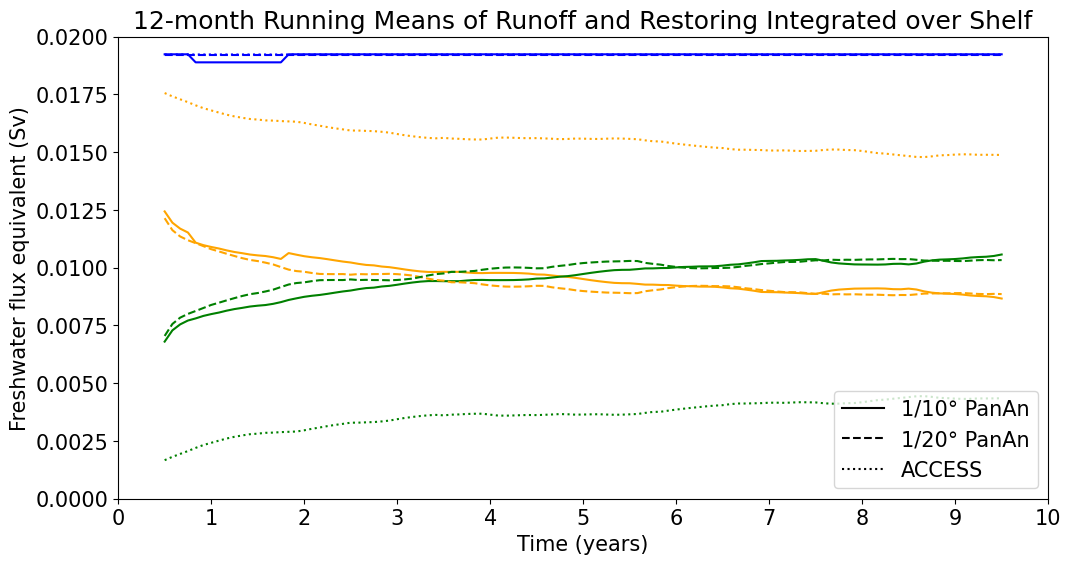

In [24]:
plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(12, 6))

# 1/10th degree PanAn
rp01_Sv.plot(label='runoff perturbation 1/10th', color='b')
rmr01_Sv.plot(label='runoff minus restoring change 1/10th', color='orange')
rc01_Sv.plot(label='restoring change 1/10th', color='g')

# 1/20th degree PanAn
rp005_Sv.plot(label='runoff perturbation 1/20th', color='b', linestyle='--')
rmr005_Sv.plot(label='runoff minus restoring change 1/20th', color='orange', linestyle='--')
rc005_Sv.plot(label='restoring change 1/20th', color='g', linestyle='--')

# ACCESS
rpacc_Sv.plot(label='runoff perturbation ACCESS', color='b', linestyle=':')
rmracc_Sv.plot(label='runoff minus restoring change ACCESS', color='orange', linestyle=':')
rcacc_Sv.plot(label='restoring change ACCESS', color='g', linestyle=':')

# Custom legend
line_10 = mlines.Line2D([], [], color='black', linestyle='-', label='1/10° PanAn')
line_20 = mlines.Line2D([], [], color='black', linestyle='--', label='1/20° PanAn')
line_ACC = mlines.Line2D([], [], color='black', linestyle=':', label='ACCESS')
plt.legend(handles=[line_10, line_20, line_ACC], loc='lower right')

# X-axis ticks in years
ticks = range(0, 121, 12)
labels = [str(i) for i in range(len(ticks))]
plt.xticks(ticks=ticks, labels=labels)
plt.xlim(0, 120)
plt.ylim(0,0.02)

plt.xlabel('Time (years)')
plt.ylabel('Freshwater flux equivalent (Sv)')
plt.title('12-month Running Means of Runoff and Restoring Integrated over Shelf')

plt.show()

In [25]:
rp005_Sv[10]

0.01919137313406229

### Bar plot

In [26]:
runoff_pert_01_Sv = runoff_pert_01 * pan01_area_sum.values / 1000 / 1e6
runoff_minus_restoring_change_01_Sv = runoff_minus_restoring_change_01 * pan01_area_sum.values / 1000 / 1e6
restoring_change_01_Sv = restoring_change_01 * pan01_area_sum.values / 1000 / 1e6

runoff_pert_005_Sv = runoff_pert_005 * pan005_area_sum.values / 1000 / 1e6
runoff_minus_restoring_change_005_Sv = runoff_minus_restoring_change_005 * pan005_area_sum.values / 1000 / 1e6
restoring_change_005_Sv = restoring_change_005 * pan005_area_sum.values / 1000 / 1e6

runoff_pert_oldacc_Sv = runoff_pert_oldacc * acc_area_sum.values / 1000 / 1e6
runoff_minus_restoring_change_oldacc_Sv = runoff_minus_restoring_change_oldacc * acc_area_sum.values / 1000 / 1e6
restoring_change_oldacc_Sv = restoring_change_oldacc * acc_area_sum.values / 1000 / 1e6

In [27]:
# Convert already-integrated fluxes to Sv
rp01_Sv  = rp01  * pan01_area_sum.values / 1000 / 1e6
rmr01_Sv = rmr01 * pan01_area_sum.values / 1000 / 1e6
rc01_Sv  = rc01  * pan01_area_sum.values / 1000 / 1e6

rp005_Sv  = rp005  * pan005_area_sum.values / 1000 / 1e6
rmr005_Sv = rmr005 * pan005_area_sum.values / 1000 / 1e6
rc005_Sv  = rc005  * pan005_area_sum.values / 1000 / 1e6

rpacc_Sv  = rp_old  * acc_area_sum.values / 1000 / 1e6
rmracc_Sv = rmr_old * acc_area_sum.values / 1000 / 1e6
rcacc_Sv  = rc_old  * acc_area_sum.values / 1000 / 1e6

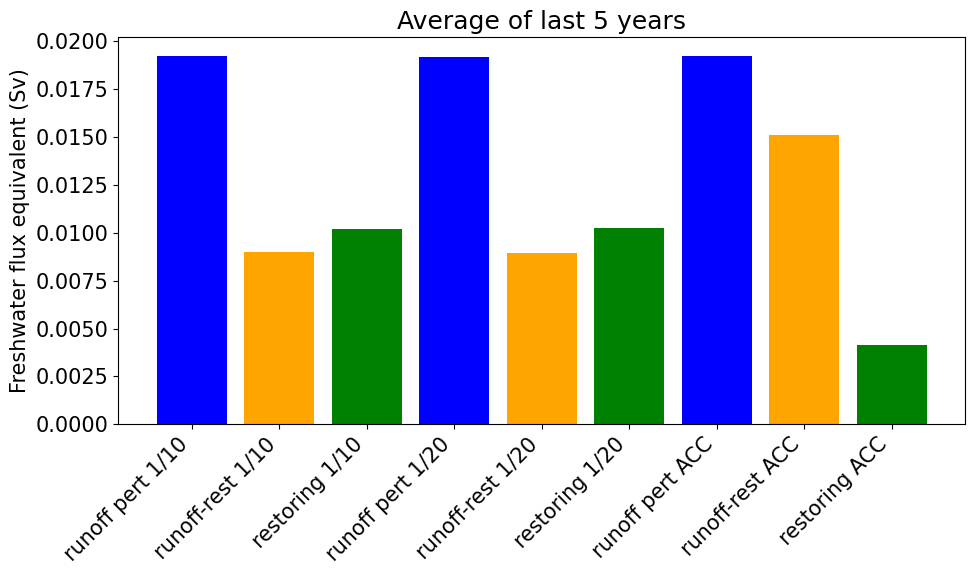

In [28]:
# Define number of months for the last 5 years
last_5yrs = 5 * 12  # 60 months

# Compute mean of last 5 years
means = {
    'runoff_pert_01': runoff_pert_01_Sv[-last_5yrs:].mean(),
    'runoff_minus_restoring_change_01': runoff_minus_restoring_change_01_Sv[-last_5yrs:].mean(),
    'restoring_change_01': restoring_change_01_Sv[-last_5yrs:].mean(),
    'runoff_pert_005': runoff_pert_005_Sv[-last_5yrs:].mean(),
    'runoff_minus_restoring_change_005': runoff_minus_restoring_change_005_Sv[-last_5yrs:].mean(),
    'restoring_change_005': restoring_change_005_Sv[-last_5yrs:].mean(),
    'runoff_pert_oldacc': runoff_pert_oldacc_Sv[-last_5yrs:].mean(),
    'runoff_minus_restoring_change_oldacc': runoff_minus_restoring_change_oldacc_Sv[-last_5yrs:].mean(),
    'restoring_change_oldacc': restoring_change_oldacc_Sv[-last_5yrs:].mean()
}

# Group labels for x-axis
labels = [
    'runoff pert 1/10', 'runoff-rest 1/10', 'restoring 1/10',
    'runoff pert 1/20', 'runoff-rest 1/20', 'restoring 1/20',
    'runoff pert ACC', 'runoff-rest ACC', 'restoring ACC'
]

# Extract values in the same order
values = [means[key] for key in means.keys()]

# Plot bar chart
plt.figure(figsize=(10,6))
colors = ['b', 'orange', 'g', 'b', 'orange', 'g', 'b', 'orange', 'g']
plt.bar(labels, values, color=colors)
plt.ylabel('Freshwater flux equivalent (Sv)')
plt.title('Average of last 5 years')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


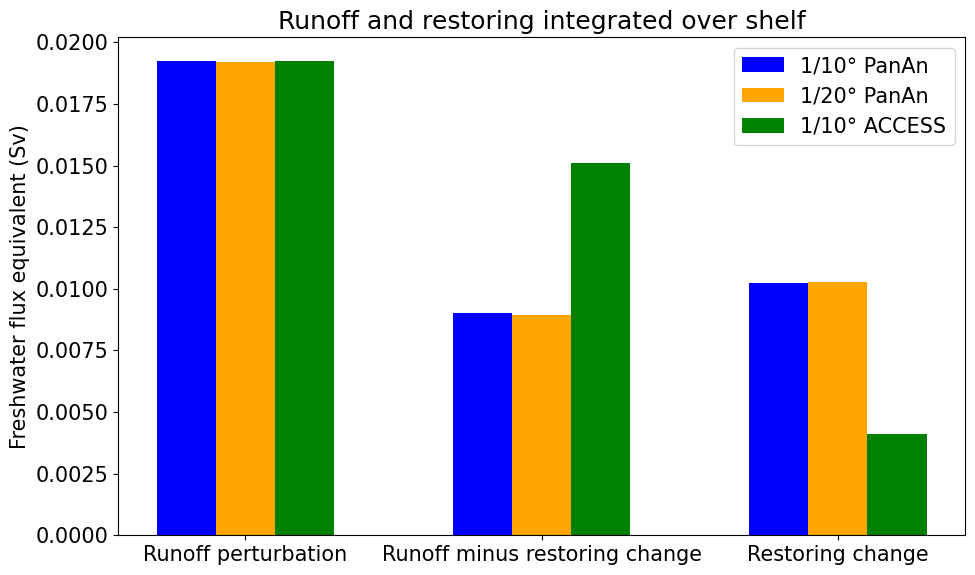

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Define groups and values
processes = ['Runoff perturbation', 'Runoff minus restoring change', 'Restoring change']
# Order: 1/10°, 1/20°, ACCESS
values_grouped = [
    [means['runoff_pert_01'], means['runoff_pert_005'], means['runoff_pert_oldacc']],
    [means['runoff_minus_restoring_change_01'], means['runoff_minus_restoring_change_005'], means['runoff_minus_restoring_change_oldacc']],
    [means['restoring_change_01'], means['restoring_change_005'], means['restoring_change_oldacc']]
]

# Bar width and positions
bar_width = 0.2
x = np.arange(len(processes))  # the label locations

plt.figure(figsize=(10,6))

# Plot each resolution as a separate set
plt.bar(x - bar_width, [v[0] for v in values_grouped], width=bar_width, color='b', label='1/10° PanAn')
plt.bar(x,        [v[1] for v in values_grouped], width=bar_width, color='orange', label='1/20° PanAn')
plt.bar(x + bar_width, [v[2] for v in values_grouped], width=bar_width, color='g', label='1/10° ACCESS')

# Labels and formatting
plt.xticks(x, processes)
plt.ylabel('Freshwater flux equivalent (Sv)')
plt.title('Runoff and restoring integrated over shelf')
plt.legend()
plt.tight_layout()
plt.show()


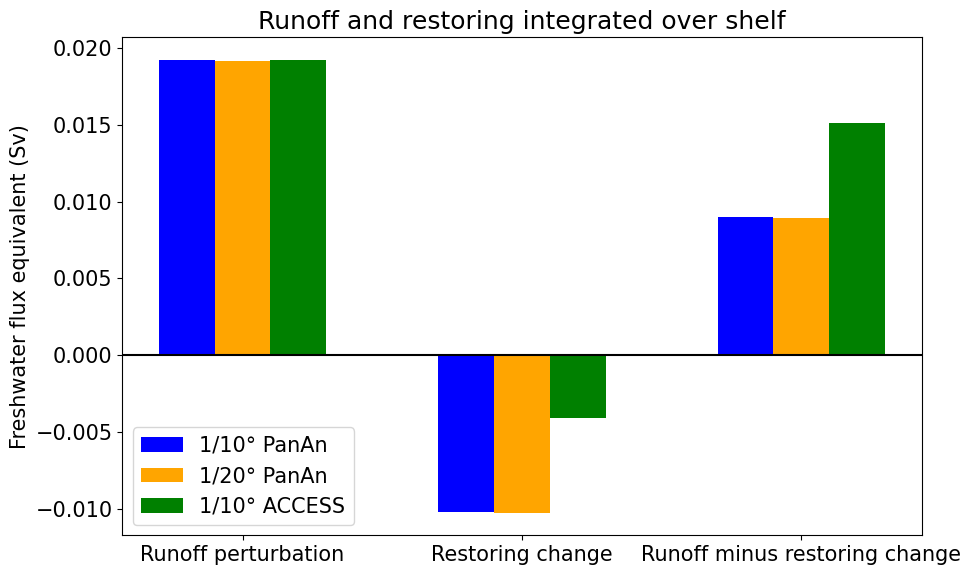

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Define groups and values
processes = ['Runoff perturbation', 'Restoring change', 'Runoff minus restoring change']
# Order: 1/10°, 1/20°, ACCESS
values_grouped = [
    [means['runoff_pert_01'], means['runoff_pert_005'], means['runoff_pert_oldacc']],
    [-means['restoring_change_01'], -means['restoring_change_005'], -means['restoring_change_oldacc']],
    [means['runoff_minus_restoring_change_01'], means['runoff_minus_restoring_change_005'], means['runoff_minus_restoring_change_oldacc']]
]

# Bar width and positions
bar_width = 0.2
x = np.arange(len(processes))  # the label locations

plt.figure(figsize=(10,6))

# Plot each resolution as a separate set
plt.bar(x - bar_width, [v[0] for v in values_grouped], width=bar_width, color='b', label='1/10° PanAn')
plt.bar(x,        [v[1] for v in values_grouped], width=bar_width, color='orange', label='1/20° PanAn')
plt.bar(x + bar_width, [v[2] for v in values_grouped], width=bar_width, color='g', label='1/10° ACCESS')

# Labels and formatting
plt.axhline(y=0, color='black', linestyle='-')
plt.xticks(x, processes)
plt.ylabel('Freshwater flux equivalent (Sv)')
plt.title('Runoff and restoring integrated over shelf')
plt.legend()
plt.tight_layout()
plt.show()
